In [209]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import pandas as pd
from pydub import AudioSegment, effects
import librosa
from deepface import DeepFace
import noisereduce as nr
import tensorflow as tf
from scipy.special import softmax
import librosa
import noisereduce as nr  # Import the noise reduction library

## LOADING MODELS

In [210]:
# FER2013 = load_model('Weights/FER2013_NoDC_BEST.keras')
# FER2013 = load_model('Weights/FER2013_NoSC_BEST.keras')

textModelName = "michellejieli/emotion_text_classifier"
# FER2013 = load_model('Weights/FER2013_noSC_Balanced.keras')
AffectNET = load_model('Weights/AffectNet_NoSC_S224.keras')
SER = load_model('/home/group02-f24/Documents/Zoghby/ColabNotebooks5/best_weights_noSC.keras')

model_name = "michellejieli/emotion_text_classifier"
config = AutoConfig.from_pretrained(model_name)
config.num_labels = 6
tokenizer = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")
textModel = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True
)
textModel.load_state_dict(torch.load("Weights/Classifier_withNoSurprise_FineTuned.pth"))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at michellejieli/emotion_text_classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## Inputs

In [211]:
voicePath = "/home/group02-f24/Desktop/Record (online-voice-recorder.com).mp3"
img = cv2.imread("/home/group02-f24/Desktop/Pics/n.jpg")
DeepFaceImg = img
img = img.astype('float32') / 255.0  # Normalize if needed
textInput = "I am disgusted from your behavior"
affectNetAccuracy = 0.68
serAccuracy = 0.91
textclassAccuracy = 0.945
deepFaceAccuracy = 0.9
finalEmotion = ''
concPred = np.zeros((1, 7))


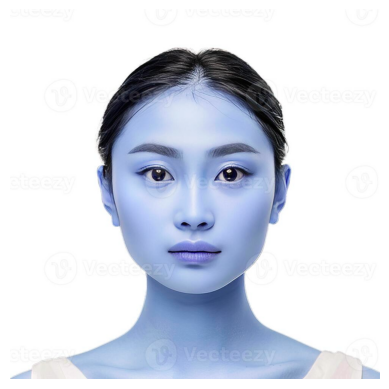

In [212]:
# plot the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

#### MAPPING

In [213]:
emotionMapping = {'0': 'Anger', '1': 'Fear', '2': 'Happiness', '3': 'Sadness', '4': 'Disgust', '5': 'Neutral'}
SER_labels = {0:'Neutral', 1:'Neutral', 2:'Happiness', 3:'Sadness', 4:'Anger', 5:'Fear', 6:'Disgust', 7:'Surprise'}
Text_Emotion_labels = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4:'Neutral', 5:'Sadness'}

# Reverse mapping from emotion name to new label
reverse_mapping = {v: int(k) for k, v in emotionMapping.items()}

# Initialize new mappings
TextClasifiedLabels = {}
SERClasifiedLabels = {}

# Map Text Emotion Classifier labels
for i, label in Text_Emotion_labels.items():
    if label in reverse_mapping:
        TextClasifiedLabels[i] = reverse_mapping[label]  # map old index to new index

# Map SER labels
for i, label in SER_labels.items():
    if label in reverse_mapping:
        SERClasifiedLabels[i] = reverse_mapping[label]  # map old index to new index

# Print results
print(reverse_mapping)
print("Mapped Text label indices:", TextClasifiedLabels)
print("Mapped SER label indices:", SERClasifiedLabels)

{'Anger': 0, 'Fear': 1, 'Happiness': 2, 'Sadness': 3, 'Disgust': 4, 'Neutral': 5}
Mapped Text label indices: {0: 0, 1: 4, 2: 1, 3: 2, 4: 5, 5: 3}
Mapped SER label indices: {0: 5, 1: 5, 2: 2, 3: 3, 4: 0, 5: 1, 6: 4}


In [214]:
print('SER input shape: ',SER.input_shape)
# print('FER2013 input shape: ',FER2013.input_shape)
print('AffectNET input shape: ',AffectNET.input_shape)
textModel.eval()

SER input shape:  (None, 335, 50)
AffectNET input shape:  (None, 224, 224, 3)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

# Text Function

In [215]:
def predict_emotion(model, text):

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    predicted_emotion = TextClasifiedLabels[predicted_class]
    return predicted_emotion,predicted_class, probs.numpy()


## Voice Preprocess

In [216]:
def preprocess_audio_file(file_path, total_length=173056, target_sr=22050, top_db=30):
    # Load using pydub (for normalization)
    rawsound = AudioSegment.from_file(file_path)
    normalized = effects.normalize(rawsound, headroom=5.0)
    samples = np.array(normalized.get_array_of_samples(), dtype='float32')
    max_val = float(2 ** (8 * rawsound.sample_width - 1))
    samples = samples / max_val
    
    trimmed, _ = librosa.effects.trim(samples, top_db=top_db)
    
    if len(trimmed) < total_length:
        padded = np.pad(trimmed, (0, total_length - len(trimmed)), mode='constant')
    else:
        padded = trimmed[:total_length]
    
    sr_orig = rawsound.frame_rate
    if sr_orig != target_sr:
        padded = librosa.resample(padded, orig_sr=sr_orig, target_sr=target_sr)
        sr = target_sr
    else:
        sr = sr_orig
    reduced = nr.reduce_noise(y=padded, sr=sr)
    
    return reduced, sr

total_length = 173056
frame_length = 2048
hop_length = 512
expected_frames = 1 + int((total_length - frame_length) / hop_length)

def extract_features_fixed(signal, sr, frame_length=2048, hop_length=512, n_mfcc=13, expected_frames=expected_frames):
    rms = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length)
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=frame_length, hop_length=hop_length, center=True)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=signal, sr=sr, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr, hop_length=hop_length)
    
    features = np.vstack((zcr, rms, mfcc, mfcc_delta, mfcc_delta2, centroid, contrast, rolloff)).T
    current_frames = features.shape[0]
    
    if current_frames < expected_frames:
        pad_width = expected_frames - current_frames
        features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
    elif current_frames > expected_frames:
        features = features[:expected_frames, :] 
    return features

def PredictSER(model, file_path, total_length=173056, target_sr=22050, top_db=30,frame_length=2048, hop_length=512, n_mfcc=13, expected_frames=335):  
    # Preprocess the audio file
    signal, sr = preprocess_audio_file(file_path, total_length=total_length, target_sr=target_sr, top_db=top_db)
    
    # Extract features with fixed number of frames
    features = extract_features_fixed(signal, sr, frame_length=frame_length, hop_length=hop_length, n_mfcc=n_mfcc, expected_frames=expected_frames)

    X_input = np.expand_dims(features, axis=0)
    predictions = model.predict(X_input)
    
    # Map predicted index to emotion
    predicted_class = np.argmax(predictions, axis=1)[0]
    emotion_map = {0: 'Neutral', 1: 'Calm', 2: 'Happiness', 3: 'Sadness', 4: 'Angry', 5: 'Fear', 6: 'Disgust', 7: 'Surprise'}
    predicted_emotion = emotion_map.get(predicted_class, "Unknown")
    
    return predictions, predicted_emotion

# FER Function

In [217]:
def fer2013inputshape(img):
    img = cv2.resize(img, (48, 48))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

# AffectNet Function

In [218]:
def AffectNetinputshape(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

In [219]:
def SERinputshape(wav):
    wav = np.pad(wav, (0, 335-len(wav)), 'constant', constant_values=(0, 0))
    wav = np.expand_dims(wav, axis=-1)
    wav = np.expand_dims(wav, axis=0)
    return wav

In [220]:
FER2013img = fer2013inputshape(img)
AffectNETimg = AffectNetinputshape(img)

In [221]:
FER2013img.shape

(1, 48, 48, 1)

In [222]:
AffectNETimg.shape

(1, 224, 224, 3, 1)

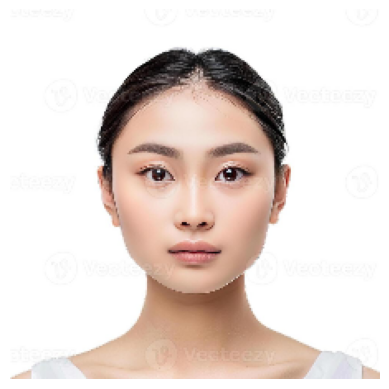

In [223]:
plt.imshow(AffectNETimg[0].reshape(224, 224, 3))
plt.axis('off')
plt.show()

In [224]:
def DeepFaceProbs(DeepFaceanalysis):
    emotions = DeepFaceanalysis[0]['emotion']

    map_from_deepface = {
        'Anger': 'angry',
        'Fear': 'fear',
        'Happiness': 'happy',
        'Sadness': 'sad',
        'Disgust': 'disgust',
        'Neutral': 'neutral'
    }
    ordered_values = []
    for key in sorted(emotionMapping.keys(), key=int):
        deepface_key = map_from_deepface[emotionMapping[key]]
        ordered_values.append(emotions.get(deepface_key, 0.0))  

    softmaxed = softmax(ordered_values)
    print("Softmaxed values: ", softmaxed)
    return softmaxed


### RAW PREDICTIONS

In [225]:
# FER2013pred = FER2013.predict(FER2013img)
AffectNETpred = affectNetAccuracy*AffectNET.predict(AffectNETimg)
emotion, predclass,probs = predict_emotion(textModel,textInput)
SERpredictions, SERpredicted_emotion = PredictSER(SER, voicePath)
SERpredictions = SERpredictions.flatten()
# DeepFace analysis
DeepFaceanalysis = DeepFace.analyze(DeepFaceImg, actions=['emotion'], enforce_detection=False)
deepFaceProbs = deepFaceAccuracy*DeepFaceProbs(DeepFaceanalysis)

probs = textclassAccuracy*probs[0, :6]

reordered_preds = np.zeros_like(probs)
reordered_predsSER = np.zeros_like(SERpredictions)

for old_idx, new_idx in SERClasifiedLabels.items():
    reordered_predsSER[new_idx] = SERpredictions[old_idx]

for old_idx, new_idx in TextClasifiedLabels.items():
    reordered_preds[new_idx] = probs[old_idx]

SERpredictions = serAccuracy*reordered_predsSER [0:6] 
probs = reordered_preds

# FER2013pred = softmax(FER2013pred)
# AffectNETpred = softmax(AffectNETpred)
# probs = softmax(probs)
# SERpredictions = softmax(SERpredictions)

# FER2013pred = FER2013pred.round(3)
AffectNETpred = AffectNETpred.round(3)
probs = probs.round(3)
SERpredictions = SERpredictions.round(3)
facialEmotions = AffectNETpred + deepFaceProbs
facialEmotions = facialEmotions/np.max(facialEmotions)

# print('FER2013 prediction: ',FER2013pred)
print('AffectNET prediction: ',AffectNETpred)
print('Text prediction: ',probs)
print('SER prediction: ',SERpredictions)
print('analysis: ',deepFaceProbs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Softmaxed values:  [1.34263825e-40 3.42354799e-41 3.18256918e-41 5.99775878e-39
 3.18256627e-41 1.00000000e+00]
AffectNET prediction:  [[0.033 0.05  0.064 0.06  0.094 0.378]]
Text prediction:  [0.002 0.    0.    0.    0.943 0.   ]
SER prediction:  [0.728 0.095 0.06  0.012 0.012 0.   ]
analysis:  [1.20837442e-40 3.08119319e-41 2.86431226e-41 5.39798290e-39
 2.86430964e-41 9.00000000e-01]


### Normalized PREDICTIONS

In [478]:
AffectNETdomEmo = np.argmax(AffectNETpred, axis=1)
DeepFaceDomEmo = np.argmax(deepFaceProbs, axis=0)
FacialDomEmo = np.argmax(facialEmotions, axis=1)

SERemotion = SERpredicted_emotion
FacialDomEmo = emotionMapping[str(FacialDomEmo[0])]
TextDomEmo = emotionMapping[str(np.argmax(probs, axis=0))]

In [479]:
print('Text Classified Emotion:',TextDomEmo)
print('Final Facial Emotion: ',FacialDomEmo)
print('SER prediction: ',SERpredicted_emotion)

Text Classified Emotion: Disgust
Final Facial Emotion:  Neutral
SER prediction:  Happiness


In [ ]:
if (SERemotion == FacialDomEmo) and (SERemotion == TextDomEmo):
    print('All models agree on the emotion: ', SERemotion)
    finalEmotion = SERemotion
elif (SERemotion == FacialDomEmo) and (SERemotion != TextDomEmo):
    print('SER and Facial models agree on the emotion: ', SERemotion)
    finalEmotion = SERemotion
elif (SERemotion == TextDomEmo) and (SERemotion != FacialDomEmo):
    print('SER and Text models agree on the emotion: ', SERemotion)
    finalEmotion = SERemotion
elif (FacialDomEmo == TextDomEmo) and (FacialDomEmo != SERemotion):
    print('Facial and Text models agree on the emotion: ', FacialDomEmo)
    finalEmotion = FacialDomEmo
elif (SERemotion != FacialDomEmo) and (SERemotion != TextDomEmo):
    concPred = facialEmotions + probs + SERpredictions
    finalEmotion = np.argmax(concPred, axis=1)
    finalEmotion = emotionMapping[str(finalEmotion[0])]

### Concatenated Predictions

In [484]:
finalPrediction = np.argmax(concPred, axis=1)
# concPred = concPred / np.sum(concPred)
print("Final Prediction Class:", finalPrediction)
print('Final Prediction: ',emotionMapping[str(finalPrediction[0])])


Final Prediction Class: [4]
Final Prediction:  Disgust
